In [1]:
import pandas as pd
import numpy as np
import math

import itertools

import torch
import torch.nn as nn
import torchvision.transforms as tfs

from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
GRAPHS_FOLDER = 'Graphs/{}.png'

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data = pd.read_csv('nn_0.csv')
data

,X1,X2,class
0,1.017522,1.543864,-1
1,1.151304,1.724181,-1
2,1.050958,1.119564,-1
3,1.036791,0.955846,-1
4,1.154825,0.761754,-1
...,...,...,...
95,-0.414244,-0.018218,1
96,0.083760,0.185509,1
97,-0.239337,0.298548,1
98,0.196957,-0.198677,1


In [5]:
data['class'] = data['class'].replace(-1, 0)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

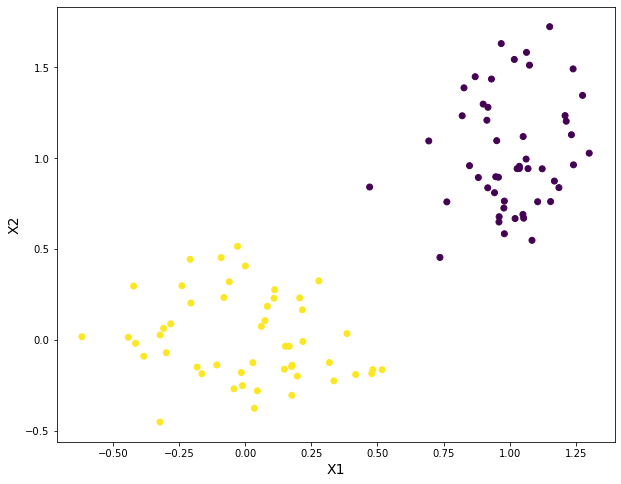

In [6]:
plt.figure(figsize=(10, 8))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1].values, c=y)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.savefig(GRAPHS_FOLDER.format('Task 1_1. Data graph'), bbox_inches='tight')
plt.show()

In [7]:
X = torch.FloatTensor(X.values).to(device)
y = torch.FloatTensor(y.values).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=62)

In [8]:
y_test

tensor([1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.], device='cuda:0')

In [9]:
print('Features', data.columns.values[:-1])
print('Classes', data['class'].unique())

Features ['X1' 'X2']
Classes [0 1]


In [10]:
def weights_init(m):
    torch.manual_seed(62)
    if isinstance(m, nn.Linear):
        stdv = 1. / math.sqrt(m.weight.size(1))
        m.weight.data.uniform_(-stdv, stdv)
        if m.bias is not None:
            m.bias.data.uniform_(-stdv, stdv)

In [11]:
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [12]:
model.apply(weights_init)

criterion = nn.L1Loss()
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
def train_nn(model, criterion, optimizer, X, y, history, epochs=100):
    for i in range(epochs + 1):
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
        
        history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [14]:
def test_nn(model, X, y):
    y_pred_list = np.array([])
    model.eval()
    with torch.no_grad():
        y_test_pred = model(X_test)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list = np.append(y_pred_list, y_pred_tag.cpu().numpy())
    
    model.train()
    correct = np.sum(y_pred_list == y_test.cpu().numpy())
    total = len(y_test)
    print('Accuracy: %d %%' % (100 * correct / total))
    return y_pred_list

In [15]:
def plot_loss_graph(data, title, xlabel, ylabel, item=None):
    plt.figure(figsize=(10, 7))

    plt.plot(data)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    if item is not None:
        plt.savefig(GRAPHS_FOLDER.format('Task ' + item + '.' + title),
            bbox_inches='tight')
    
    plt.show()

In [16]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          item=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")


    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)
    plt.tight_layout()
    if item is not None:
        plt.savefig(GRAPHS_FOLDER.format('Task ' + item + '.' + title),
            bbox_inches='tight')

In [17]:
epochs = 500
history = []

y_train = y_train.reshape(-1, 1)
train_nn(model, criterion, optimizer, X_train, y_train, history, epochs)
for i in range(0, epochs + 1, 25):
    print(f"epoch: {i}, loss: {history[i]}")

epoch: 0, loss: 0.6501739621162415
epoch: 25, loss: 0.5834963917732239
epoch: 50, loss: 0.49435877799987793
epoch: 75, loss: 0.4189416170120239
epoch: 100, loss: 0.37017735838890076
epoch: 125, loss: 0.3361147940158844
epoch: 150, loss: 0.3086370825767517
epoch: 175, loss: 0.2844974398612976
epoch: 200, loss: 0.26258447766304016
epoch: 225, loss: 0.2425849437713623
epoch: 250, loss: 0.22442860901355743
epoch: 275, loss: 0.20807065069675446
epoch: 300, loss: 0.19342559576034546
epoch: 325, loss: 0.1803649216890335
epoch: 350, loss: 0.16873446106910706
epoch: 375, loss: 0.15837296843528748
epoch: 400, loss: 0.1491248905658722
epoch: 425, loss: 0.14084775745868683
epoch: 450, loss: 0.13341499865055084
epoch: 475, loss: 0.12671640515327454
epoch: 500, loss: 0.1206570491194725


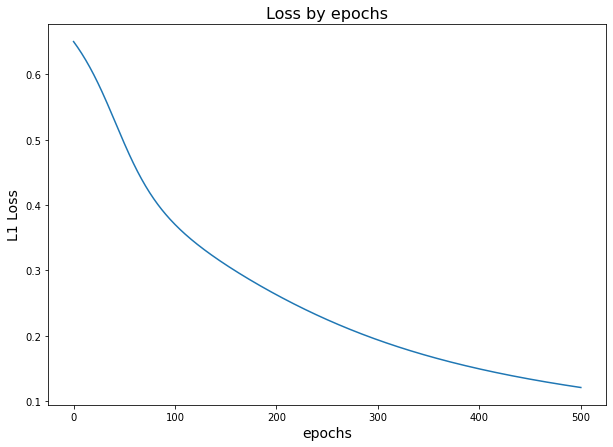

In [18]:
plot_loss_graph(history, 'Loss by epochs', 'epochs', 'L1 Loss', '1_1')

In [19]:
test_nn(model, X_test, y_test)

Accuracy: 100 %


array([1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.])

In [20]:
torch.cuda.empty_cache()

In [21]:
data = pd.read_csv('nn_1.csv')
data

,X1,X2,class
0,-0.011802,0.040455,1
1,-0.178221,0.212999,1
2,0.061962,0.186818,1
3,0.055123,0.206935,1
4,0.203488,-0.290206,1
...,...,...,...
245,0.767424,1.173810,1
246,0.869957,1.079371,1
247,1.077572,1.057825,1
248,1.130315,0.921124,1


In [22]:
data['class'] = data['class'].replace(-1, 0)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

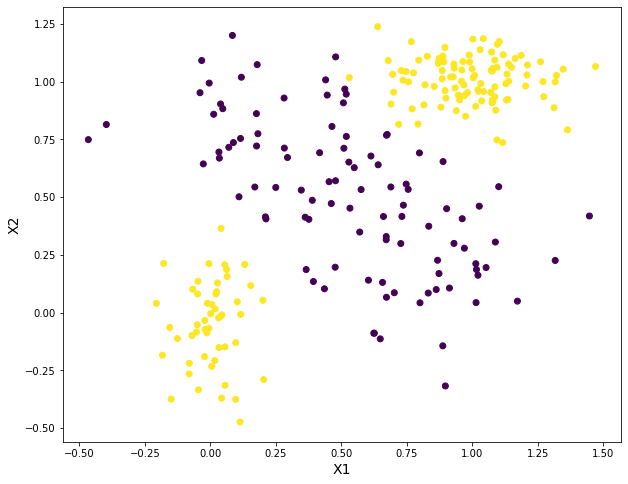

In [23]:
plt.figure(figsize=(10, 8))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1].values, c=y)
plt.xlabel('X1', fontsize=14)
plt.ylabel('X2', fontsize=14)
plt.savefig(GRAPHS_FOLDER.format('Task 1_2. Data graph'), bbox_inches='tight')
plt.show()

In [24]:
X = torch.FloatTensor(X.values).to(device)
y = torch.FloatTensor(y.values).to(device)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=62)

In [25]:
y_test

tensor([0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1.], device='cuda:0')

In [26]:
model.apply(weights_init)

criterion = nn.L1Loss()
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [27]:
epochs = 500
history = []
y_train = y_train.reshape(-1, 1)
train_nn(model, criterion, optimizer, X_train, y_train, history, epochs)
for i in range(0, epochs + 1, 25):
    print(f"epoch: {i}, loss: {history[i]}")

epoch: 0, loss: 0.46170806884765625
epoch: 25, loss: 0.456808477640152
epoch: 50, loss: 0.4534131586551666
epoch: 75, loss: 0.4509870111942291
epoch: 100, loss: 0.4491831362247467
epoch: 125, loss: 0.4477820098400116
epoch: 150, loss: 0.4466441869735718
epoch: 175, loss: 0.4456799328327179
epoch: 200, loss: 0.44483035802841187
epoch: 225, loss: 0.44405636191368103
epoch: 250, loss: 0.4433314800262451
epoch: 275, loss: 0.4426375925540924
epoch: 300, loss: 0.4419623613357544
epoch: 325, loss: 0.4412972629070282
epoch: 350, loss: 0.44063660502433777
epoch: 375, loss: 0.43997663259506226
epoch: 400, loss: 0.4393150210380554
epoch: 425, loss: 0.4386506676673889
epoch: 450, loss: 0.43798312544822693
epoch: 475, loss: 0.4373125731945038
epoch: 500, loss: 0.436639666557312


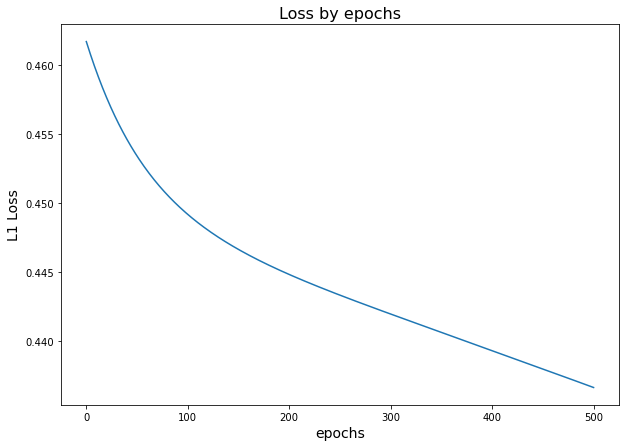

In [28]:
plot_loss_graph(history, 'Loss by epochs', 'epochs', 'L1 Loss', '1_2')

In [29]:
y_pred = test_nn(model, X_test, y_test)

Accuracy: 61 %


Confusion matrix, without normalization
[[ 0 29]
 [ 0 46]]


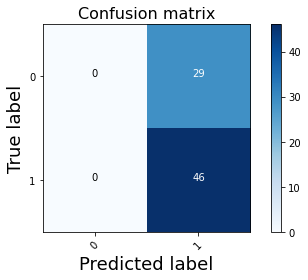

In [30]:
matrix = confusion_matrix(y_test.cpu().numpy(), y_pred)
plot_confusion_matrix(matrix, classes=['0', '1'], item='1_2')

In [31]:
torch.cuda.empty_cache()

2.

In [32]:
model.apply(weights_init)

criterion = nn.SmoothL1Loss()
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
y_train = y_train.view(-1, 1).type(torch.cuda.FloatTensor)

In [34]:
epochs = 500
history = []
train_nn(model, criterion, optimizer, X_train, y_train, history, epochs)
for i in range(0, epochs + 1, 25):
    print(f"epoch: {i}, loss: {history[i]}")

epoch: 0, loss: 0.1192101463675499
epoch: 25, loss: 0.11865539103746414
epoch: 50, loss: 0.11830906569957733
epoch: 75, loss: 0.11809533089399338
epoch: 100, loss: 0.11796338856220245
epoch: 125, loss: 0.11788079142570496
epoch: 150, loss: 0.11782758682966232
epoch: 175, loss: 0.11779172718524933
epoch: 200, loss: 0.11776606738567352
epoch: 225, loss: 0.1177464947104454
epoch: 250, loss: 0.1177305355668068
epoch: 275, loss: 0.11771684885025024
epoch: 300, loss: 0.1177046000957489
epoch: 325, loss: 0.11769334971904755
epoch: 350, loss: 0.11768282204866409
epoch: 375, loss: 0.117672860622406
epoch: 400, loss: 0.11766337603330612
epoch: 425, loss: 0.11765430122613907
epoch: 450, loss: 0.11764561384916306
epoch: 475, loss: 0.1176372542977333
epoch: 500, loss: 0.11762923747301102


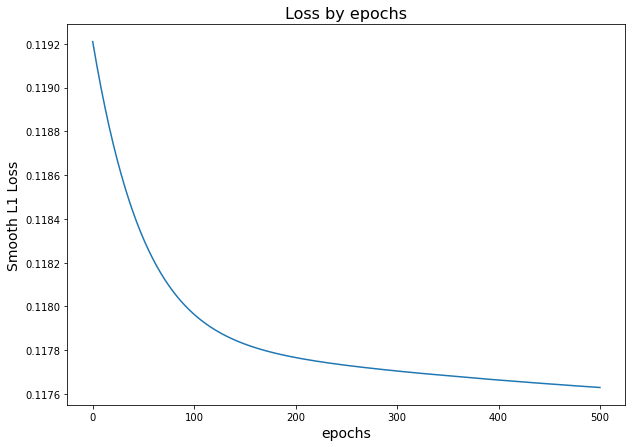

In [35]:
plot_loss_graph(history, 'Loss by epochs', 'epochs', 'Smooth L1 Loss', '2_1')

In [36]:
y_pred = test_nn(model, X_test, y_test)

Accuracy: 44 %


Confusion matrix, without normalization
[[ 2 27]
 [15 31]]


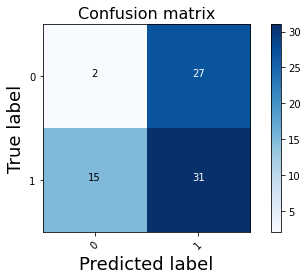

In [37]:
matrix = confusion_matrix(y_test.cpu().numpy(), y_pred)
plot_confusion_matrix(matrix, classes=['0', '1'], item='2_1')

In [38]:
torch.cuda.empty_cache()

In [39]:
model = nn.Sequential(
    nn.Linear(2, 2),
    nn.LogSigmoid()
)
model.to(device)

Sequential(
  (0): Linear(in_features=2, out_features=2, bias=True)
  (1): LogSigmoid()
)

In [40]:
model.apply(weights_init)

criterion = nn.NLLLoss()
learning_rate = 1e-1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [41]:
y_train = y_train.view(-1).type(torch.cuda.LongTensor)

In [42]:
epochs = 700
history = []
train_nn(model, criterion, optimizer, X_train, y_train, history, epochs)
for i in range(0, epochs + 1, 50):
    print(f"epoch: {i}, loss: {history[i]}")

epoch: 0, loss: 0.5766764879226685
epoch: 50, loss: 0.23415300250053406
epoch: 100, loss: 0.14556723833084106
epoch: 150, loss: 0.10501802712678909
epoch: 200, loss: 0.08186836540699005
epoch: 250, loss: 0.06694746017456055
epoch: 300, loss: 0.05655428022146225
epoch: 350, loss: 0.04891207069158554
epoch: 400, loss: 0.04306330159306526
epoch: 450, loss: 0.03844708576798439
epoch: 500, loss: 0.03471344709396362
epoch: 550, loss: 0.03163294121623039
epoch: 600, loss: 0.02904907800257206
epoch: 650, loss: 0.026851419359445572
epoch: 700, loss: 0.024959906935691833


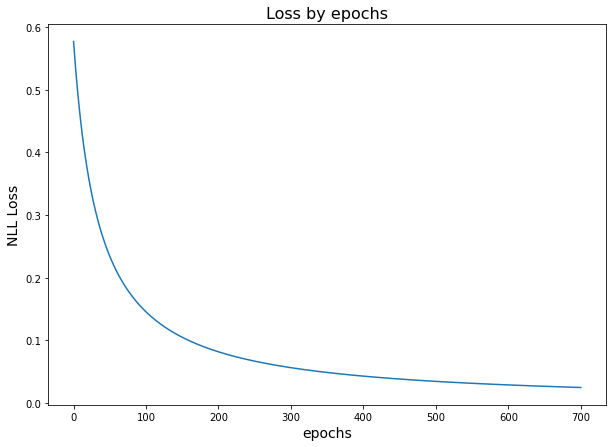

In [43]:
plot_loss_graph(history, 'Loss by epochs', 'epochs', 'NLL Loss', '2_2')

In [44]:
y_pred_list = np.array([])
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)
    y_pred_tag = torch.round(y_test_pred)
    y_pred_list = np.append(y_pred_list, y_pred_tag.cpu().numpy())
    
model.train()
total = len(y_test)
res = y_test_pred[:, [0]].view(-1).cpu().numpy() > y_test_pred[:, [-1]].view(-1).cpu().numpy()
correct = np.sum(res.astype(int) == y_test.cpu().numpy())
print('Accuracy: %d %%' % (100 * correct / total))
print(y_test.cpu())

Accuracy: 76 %
tensor([0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1.])


Confusion matrix, without normalization
[[26  3]
 [15 31]]


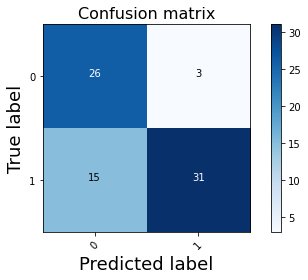

In [45]:
matrix = confusion_matrix(y_test.cpu().numpy(), res.astype(int))
plot_confusion_matrix(matrix, classes=['0', '1'], item='2_2')

In [46]:
torch.cuda.empty_cache()

3.

In [47]:
input_size = 28 * 28
num_classes = 10
num_epochs = 5
batch_size = 100

In [48]:
data_tfs = tfs.Compose([
  tfs.ToTensor(),
  tfs.Normalize((0.5), (0.5))
])

In [49]:
root = './'
train = MNIST(root, train=True,  transform=data_tfs, download=True)
test  = MNIST(root, train=False, transform=data_tfs, download=True)

In [50]:
train_loader = DataLoader(train, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, drop_last=True)

In [51]:
model = nn.Linear(input_size, num_classes)
model.to(device)

Linear(in_features=784, out_features=10, bias=True)

In [52]:
model.apply(weights_init)

criterion = nn.CrossEntropyLoss()      # (logsoftmax + negative likelihood) in its core, applied to logits
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
epochs = 3
history = []

In [53]:
def train_nn_mnist(model, criterion, optimizer, train_loader, history=None):
    for i in range(epochs):
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)

            logits = model(x_batch)

            loss = criterion(logits, y_batch)
            if history is not None:
                history.append(loss.item())

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

        print(f'{i+1},\t loss: {loss.item()}')

In [54]:
def test_nn_mnist(model, test_loader):
    with torch.no_grad():
        acc = 0
        batches = 0
        for x_batch, y_batch in test_loader:
            batches += 1
            x_batch = x_batch.view(x_batch.shape[0], -1).to(device)
            y_batch = y_batch.to(device)

            preds = torch.argmax(model(x_batch), dim=1)
            acc += (preds == y_batch).cpu().numpy().mean()
        print('Accuracy: %d %%' % (100 * acc / batches))

In [55]:
train_nn_mnist(model, criterion, optimizer, train_loader, history)

1,	 loss: 1.2473645210266113
2,	 loss: 0.9182429313659668
3,	 loss: 0.768842875957489


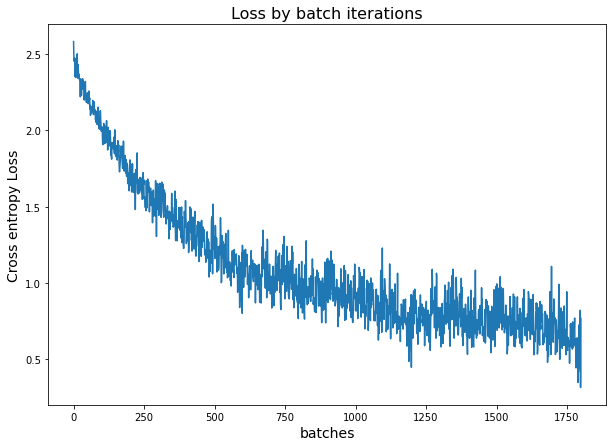

In [56]:
plot_loss_graph(history, 'Loss by batch iterations', 'batches', 'Cross entropy Loss', '3_1')

In [57]:
test_nn_mnist(model, test_loader)

Accuracy: 85 %


In [58]:
torch.cuda.empty_cache()

In [59]:
model = nn.Sequential(
    nn.Linear(input_size, 64),
    nn.ReLU(),
    nn.Linear(64, num_classes )
)
model.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=10, bias=True)
)

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, betas=(0.9, 0.99))
epochs = 3
history = []

In [61]:
train_nn_mnist(model, criterion, optimizer, train_loader, history)

1,	 loss: 0.3785141110420227
2,	 loss: 0.30805590748786926
3,	 loss: 0.27937641739845276


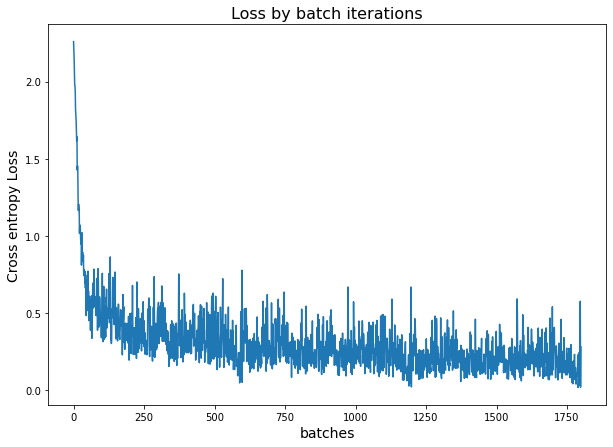

In [62]:
plot_loss_graph(history, 'Loss by batch iterations', 'batches', 'Cross entropy Loss', '3_2')

In [63]:
test_nn_mnist(model, test_loader)

Accuracy: 94 %


In [64]:
torch.cuda.empty_cache()